## Twitter sentiment natural language processing analysis

### Stakeholder: A marketing team at a technology company

### Business Problem Statement: 
The marketing team wants to understand consumer sentiment towards Apple and Google products. They wish to explore  emotions, and sentiments expressed by users of Apple and Google products.They need insights that can inform marketing strategies, brand perception, and customer satisfaction initiatives for their target audience.


### The main business objective is:
- What is the overall sentiment towards Apple and Google products on Twitter 

### The specific business objectives to be answered include:
- Are there any recurring themes or topics associated with positive or negative sentiments towards these brands?
- Are there any notable differences in sentiment between Apple and Google products?


### Importing the necessary packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
import string
import re
from nltk import FreqDist

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

[nltk_data] Downloading package punkt to /home/kinoti/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/kinoti/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/kinoti/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/kinoti/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
df = pd.read_csv('tweet_product_company.csv', encoding='unicode_escape')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [3]:
df.shape

(9093, 3)

In [4]:
df.is_there_an_emotion_directed_at_a_brand_or_product.value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [5]:
df.rename(columns ={'is_there_an_emotion_directed_at_a_brand_or_product' : 'sentiment', 'emotion_in_tweet_is_directed_at' : 'brand'}, inplace= True)

In [6]:
df['sentiment'] = df['sentiment'].replace('No emotion toward brand or product', 'neutral')

<Axes: xlabel='sentiment', ylabel='count'>

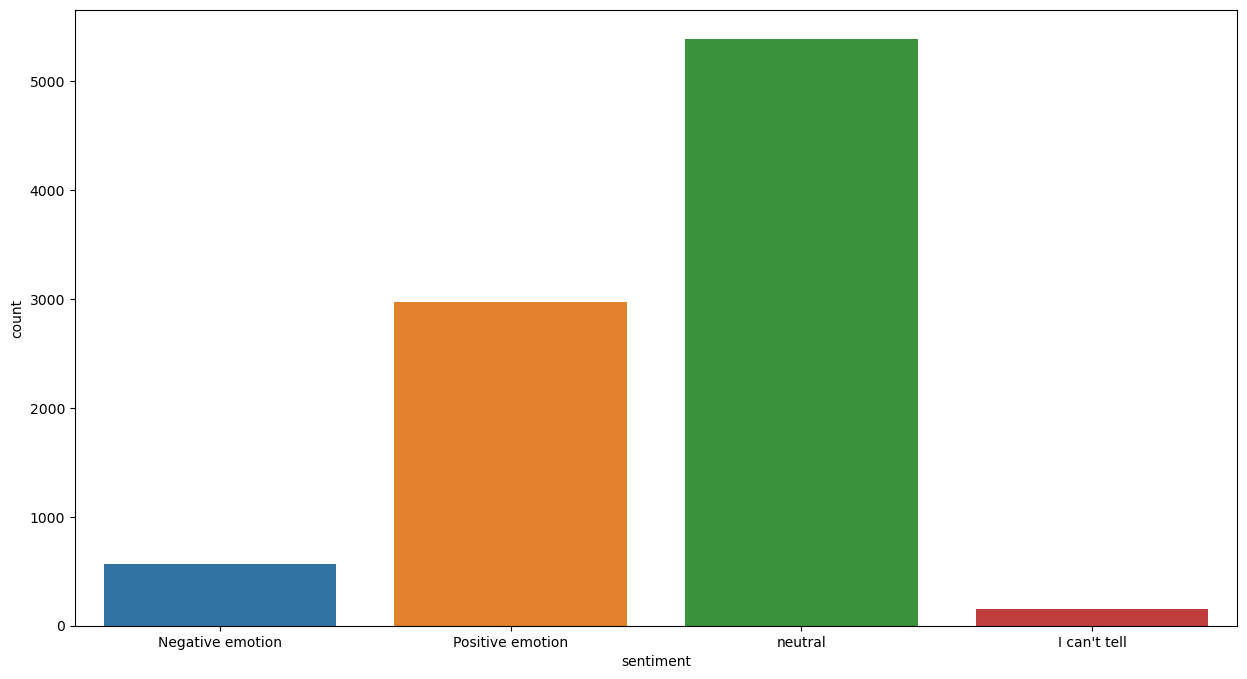

In [7]:
plt.figure(figsize = (15,8))
sns.countplot(x='sentiment', data= df)

In [8]:
df.isna().sum()

tweet_text       1
brand         5802
sentiment        0
dtype: int64

In [9]:
df['tweet_text'] = df['tweet_text'].str.lower()
df['brand'] = df['brand'].str.lower()

In [10]:
missing_brand_df = df[df['brand'].isna()]
missing_brand_df.head(10)

,tweet_text,brand,sentiment
5,@teachntech00 new ipad apps for #speechtherapy...,NaN,neutral
6,NaN,NaN,neutral
16,holler gram for ipad on the itunes app store -...,NaN,neutral
32,"attn: all #sxsw frineds, @mention register fo...",NaN,neutral
33,anyone at #sxsw want to sell their old ipad?,NaN,neutral
34,anyone at #sxsw who bought the new ipad want ...,NaN,neutral
35,at #sxsw. oooh. rt @mention google to launch ...,NaN,neutral
37,spin play - a new concept in music discovery f...,NaN,neutral
39,vatornews - google and apple force print media...,NaN,neutral
41,hootsuite - hootsuite mobile for #sxsw ~ updat...,NaN,neutral


In [11]:
missing_brand_df.shape

(5802, 3)

In [12]:
df.brand.value_counts()

ipad                               946
apple                              661
ipad or iphone app                 470
google                             430
iphone                             297
other google product or service    293
android app                         81
android                             78
other apple product or service      35
Name: brand, dtype: int64

In [13]:
# Replace missing values with an empty string
# df['tweet_text'] = df['tweet_text'].fillna('')
df.dropna(subset=['tweet_text'], inplace=True)
missing_brand_df.dropna(subset=['tweet_text'], inplace=True)

# Define the keywords to search for
keywords = ['apple', 'ipad or iphone app', 'google', 'iphone', 'other google product or service', 'android app', 'android', 'other apple product or service', 'ipad', 'itunes']

# Search for keywords in 'tweet_text' column
filtered_df = missing_brand_df[missing_brand_df['tweet_text'].str.contains('|'.join(keywords), case=False)]


/tmp/ipykernel_24269/4002662394.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_brand_df.dropna(subset=['tweet_text'], inplace=True)


In [14]:
filtered_df.head(10)

,tweet_text,brand,sentiment
5,@teachntech00 new ipad apps for #speechtherapy...,NaN,neutral
16,holler gram for ipad on the itunes app store -...,NaN,neutral
32,"attn: all #sxsw frineds, @mention register fo...",NaN,neutral
33,anyone at #sxsw want to sell their old ipad?,NaN,neutral
34,anyone at #sxsw who bought the new ipad want ...,NaN,neutral
35,at #sxsw. oooh. rt @mention google to launch ...,NaN,neutral
37,spin play - a new concept in music discovery f...,NaN,neutral
39,vatornews - google and apple force print media...,NaN,neutral
41,hootsuite - hootsuite mobile for #sxsw ~ updat...,NaN,neutral
42,hey #sxsw - how long do you think it takes us ...,NaN,neutral


In [15]:
filtered_df.shape

(5095, 3)

In [16]:
# Assign the keyword value to the 'brand' column
filtered_df['brand'] = filtered_df['tweet_text'].apply(lambda x: next((word for word in keywords if word in x), None))

/tmp/ipykernel_24269/2583434774.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['brand'] = filtered_df['tweet_text'].apply(lambda x: next((word for word in keywords if word in x), None))


In [17]:
filtered_df.head(10)

,tweet_text,brand,sentiment
5,@teachntech00 new ipad apps for #speechtherapy...,ipad,neutral
16,holler gram for ipad on the itunes app store -...,ipad,neutral
32,"attn: all #sxsw frineds, @mention register fo...",android,neutral
33,anyone at #sxsw want to sell their old ipad?,ipad,neutral
34,anyone at #sxsw who bought the new ipad want ...,ipad,neutral
35,at #sxsw. oooh. rt @mention google to launch ...,google,neutral
37,spin play - a new concept in music discovery f...,ipad,neutral
39,vatornews - google and apple force print media...,apple,neutral
41,hootsuite - hootsuite mobile for #sxsw ~ updat...,iphone,neutral
42,hey #sxsw - how long do you think it takes us ...,iphone,neutral


In [18]:
filtered_df.shape

(5095, 3)

In [19]:
filtered_df.isna().sum()

tweet_text    0
brand         0
sentiment     0
dtype: int64

- df-doesn`t have any missing values= 9093
- missing_brand_df= 5802
- filtered_df = 5095
- result_df = 707
- concatenated_df = 8386


In [20]:
# Convert the relevant columns to sets
missing_brand_set = set(missing_brand_df.index)
filtered_set = set(filtered_df.index)

# Find the rows in missing_brand_df not in filtered_df using set difference
result_set = missing_brand_set - filtered_set

# Create the resulting DataFrame
result_df = df.loc[result_set]

# Display the resulting DataFrame
pd.set_option('display.max_colwidth', None)
result_df.tail(20)


,tweet_text,brand,sentiment
6095,"rt @mention if you are attending #sxsw, please bring your old mobile phones for the hope phones project {link} @mention",NaN,neutral
8142,#sxsw #sxswi @mention is holding a secret show ft. mister heavenly+michael cera at 5. free beer at 4. location: {link},NaN,neutral
8144,day 4: sxswi wrap-up with tracy shea @mention and rick and bobby liebling @mention - {link} #sxsw #hotsheet,NaN,neutral
2007,"lonely planet has made the austin guide free for #sxsw grab it, you never know when you will need it. {link}",NaN,neutral
4055,no umbrella when you have &quot;the list&quot; via @mention ÷¼ are you all set? ÷_ {link} ÷_ #edchat #musedchat #sxsw #sxswi #newtwitter,NaN,neutral
8156,"#wahoos #sxsw party free beers, tacos, and ritas thurs.\n{link}",NaN,neutral
6110,rt @mention if you're at #sxsw : meet us at fado. we will give you wristbands that magically lead to beer. come say hi! {link},NaN,neutral
2016,@mention announces #windowsphone app today #sxsw {link} #wp7,NaN,neutral
4065,"24 hours later, we retreat back to our hotel, bushwhacked. ringo deathstarr'd, never seen so many effects pedals #sxsw {link}",NaN,neutral
4066,grab the latest @mention before #sxsw! {link},NaN,neutral


In [21]:
result_df.shape

(706, 3)

In [22]:
707/9093

0.07775211701308699

In [23]:
df_brand_present = df[df['brand'].notna()]
# Assuming 'df_brand_present' and 'filtered_df' are your DataFrames
concatenated_df = pd.concat([df_brand_present, filtered_df], ignore_index=True)

# Display the concatenated DataFrame
concatenated_df.head(10)


,tweet_text,brand,sentiment
0,".@wesley83 i have a 3g iphone. after 3 hrs tweeting at #rise_austin, it was dead! i need to upgrade. plugin stations at #sxsw.",iphone,Negative emotion
1,"@jessedee know about @fludapp ? awesome ipad/iphone app that you'll likely appreciate for its design. also, they're giving free ts at #sxsw",ipad or iphone app,Positive emotion
2,@swonderlin can not wait for #ipad 2 also. they should sale them down at #sxsw.,ipad,Positive emotion
3,@sxsw i hope this year's festival isn't as crashy as this year's iphone app. #sxsw,ipad or iphone app,Negative emotion
4,"@sxtxstate great stuff on fri #sxsw: marissa mayer (google), tim o'reilly (tech books/conferences) &amp; matt mullenweg (wordpress)",google,Positive emotion
5,"#sxsw is just starting, #ctia is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan",android,Positive emotion
6,beautifully smart and simple idea rt @madebymany @thenextweb wrote about our #hollergram ipad app for #sxsw! http://bit.ly/ieavob,ipad or iphone app,Positive emotion
7,counting down the days to #sxsw plus strong canadian dollar means stock up on apple gear,apple,Positive emotion
8,excited to meet the @samsungmobileus at #sxsw so i can show them my sprint galaxy s still running android 2.1. #fail,android,Positive emotion
9,find &amp; start impromptu parties at #sxsw with @hurricaneparty http://bit.ly/gvlrin i can't wait til the android app comes out.,android app,Positive emotion


In [24]:
concatenated_df.shape

(8386, 3)

In [25]:
concatenated_df.isna().sum()

tweet_text    0
brand         0
sentiment     0
dtype: int64

### Dropping duplicates

In [26]:
duplicates_df = concatenated_df[concatenated_df.duplicated()]

In [27]:
duplicates_df.head(20)

,tweet_text,brand,sentiment
197,"before it even begins, apple wins #sxsw {link}",apple,Positive emotion
198,"before it even begins, apple wins #sxsw {link}",apple,Positive emotion
272,"if you're in a room full of people w/good wi-fi at #sxsw run #frostwire on your android {link} share pics, apps, vids w/others",android app,Positive emotion
970,counting down the days to #sxsw plus strong canadian dollar means stock up on apple gear,apple,Positive emotion
1445,win free ipad 2 from webdoc.com #sxsw rt,ipad,Positive emotion
1499,really enjoying the changes in gowalla 3.0 for android! looking forward to seeing what else they &amp; foursquare have up their sleeves at #sxsw,android app,Positive emotion
1507,"#sxsw is just starting, #ctia is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan",android,Positive emotion
1901,"oh. my. god. the #sxsw app for ipad is pure, unadulterated awesome. it's easier to browse events on ipad than on the website!!!",ipad or iphone app,Positive emotion
2322,rt @mention marissa mayer: google will connect the digital &amp; physical worlds through mobile - {link} #sxsw,google,Positive emotion
2323,rt @mention marissa mayer: google will connect the digital &amp; physical worlds through mobile - {link} #sxsw,google,Positive emotion


In [28]:
concatenated_df.drop_duplicates(inplace=True)

In [29]:
concatenated_df.shape

(8347, 3)

### Preprocessing
We will start by preprocessing the text data. We will follow the steps listed below

* Remove punctuations and urls
* Tokenize (split text into words)
* Remove stopwords
* Lemmatization of words
#### Remove punctuations and urls
We will create 2 functions below to help us in removing the punctuations and urls

In [30]:
# remove punctuations
def remove_punc(text):
    exclude = string.punctuation
    for char in exclude:
        text = text.replace(char,'')
    return text

In [31]:
# apply the remove punctuation funtion on the tweet_text column
concatenated_df['tweet_text'] = concatenated_df.tweet_text.apply(remove_punc)
concatenated_df.head()

,tweet_text,brand,sentiment
0,wesley83 i have a 3g iphone after 3 hrs tweeting at riseaustin it was dead i need to upgrade plugin stations at sxsw,iphone,Negative emotion
1,jessedee know about fludapp awesome ipadiphone app that youll likely appreciate for its design also theyre giving free ts at sxsw,ipad or iphone app,Positive emotion
2,swonderlin can not wait for ipad 2 also they should sale them down at sxsw,ipad,Positive emotion
3,sxsw i hope this years festival isnt as crashy as this years iphone app sxsw,ipad or iphone app,Negative emotion
4,sxtxstate great stuff on fri sxsw marissa mayer google tim oreilly tech booksconferences amp matt mullenweg wordpress,google,Positive emotion


In [32]:
#remove urls
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)

#apply the function on the dataset
concatenated_df['tweet_text'] = concatenated_df['tweet_text'].apply(lambda x: cleaning_URLs(x))
concatenated_df.tail()

,tweet_text,brand,sentiment
8381,mention yup but i dont have a third app yet im on android any suggestions sxsw cc mention,android,neutral
8382,wave buzz rt mention we interrupt your regularly scheduled sxsw geek programming with big news link google circles,google,neutral
8383,googles zeiger a physician never reported potential ae yet fda relies on physicians quotwere operating wout dataquot sxsw health2dev,google,neutral
8384,some verizon iphone customers complained their time fell back an hour this weekend of course they were the new yorkers who attended sxsw,iphone,neutral
8385,ï¡ïàüêîò£áââ£âûârt mention google tests ûïcheckin offersû at sxsw link,google,neutral


In [33]:
# remove symbols, emoticons etc
def remove_emoticons(text):
    emoticon_pattern = re.compile(
        "(["
        "\U0001F600-\U0001F64F"  # Emoticons
        "\U0001F300-\U0001F5FF"  # Symbols & Pictographs
        "\U0001F680-\U0001F6FF"  # Transport & Map Symbols
        "\U0001F1E0-\U0001F1FF"  # Flags (iOS)
        "])"
    )
    return emoticon_pattern.sub(r"", text)

concatenated_df['tweet_text'] = concatenated_df['tweet_text'].apply(lambda x: remove_emoticons(x))
concatenated_df.tail()

,tweet_text,brand,sentiment
8381,mention yup but i dont have a third app yet im on android any suggestions sxsw cc mention,android,neutral
8382,wave buzz rt mention we interrupt your regularly scheduled sxsw geek programming with big news link google circles,google,neutral
8383,googles zeiger a physician never reported potential ae yet fda relies on physicians quotwere operating wout dataquot sxsw health2dev,google,neutral
8384,some verizon iphone customers complained their time fell back an hour this weekend of course they were the new yorkers who attended sxsw,iphone,neutral
8385,ï¡ïàüêîò£áââ£âûârt mention google tests ûïcheckin offersû at sxsw link,google,neutral


The last row's text is an encoded string, thus we will drop this row

In [34]:
# drop the last row
concatenated_df= concatenated_df.drop(concatenated_df.index[-1])
concatenated_df.tail()

,tweet_text,brand,sentiment
8380,google says want to give a lightning talk to a h4ckers audience at sxsw tonight email benmcgraw mention gmailcom for a spot on stage,google,neutral
8381,mention yup but i dont have a third app yet im on android any suggestions sxsw cc mention,android,neutral
8382,wave buzz rt mention we interrupt your regularly scheduled sxsw geek programming with big news link google circles,google,neutral
8383,googles zeiger a physician never reported potential ae yet fda relies on physicians quotwere operating wout dataquot sxsw health2dev,google,neutral
8384,some verizon iphone customers complained their time fell back an hour this weekend of course they were the new yorkers who attended sxsw,iphone,neutral


#### Tokenize
Now we will tokenize all the cleaned tweets in our dataset. Tokens are individual terms or words, and tokenization is the process of splitting a string of text into tokens.


In [35]:
def tokenize_text(text):
    return word_tokenize(text)

concatenated_df['tweet_text'] = concatenated_df['tweet_text'].apply(tokenize_text)
concatenated_df.head()

,tweet_text,brand,sentiment
0,"[wesley83, i, have, a, 3g, iphone, after, 3, hrs, tweeting, at, riseaustin, it, was, dead, i, need, to, upgrade, plugin, stations, at, sxsw]",iphone,Negative emotion
1,"[jessedee, know, about, fludapp, awesome, ipadiphone, app, that, youll, likely, appreciate, for, its, design, also, theyre, giving, free, ts, at, sxsw]",ipad or iphone app,Positive emotion
2,"[swonderlin, can, not, wait, for, ipad, 2, also, they, should, sale, them, down, at, sxsw]",ipad,Positive emotion
3,"[sxsw, i, hope, this, years, festival, isnt, as, crashy, as, this, years, iphone, app, sxsw]",ipad or iphone app,Negative emotion
4,"[sxtxstate, great, stuff, on, fri, sxsw, marissa, mayer, google, tim, oreilly, tech, booksconferences, amp, matt, mullenweg, wordpress]",google,Positive emotion


#### Check and Remove Stopwords
The stop words are used to eliminate unimportant words, allowing applications to focus on the important words instead.They provide no meaningful information, especially if we are building a text classification model. Therefore, we have to remove stopwords from our dataset.
As the frequency of stop words are too high, removing them results in much smaller data in terms of size. Reduced size results in faster computations on text data and the text classification model need to deal

Text document is generally made up of characters, words, sentences, paragraphs, etc. If we want to get the intuition of text data then we  do basic statistical analysis by exploring word frequency distribution in the data.

Below we plot the most frequent word distribution across different sentiments

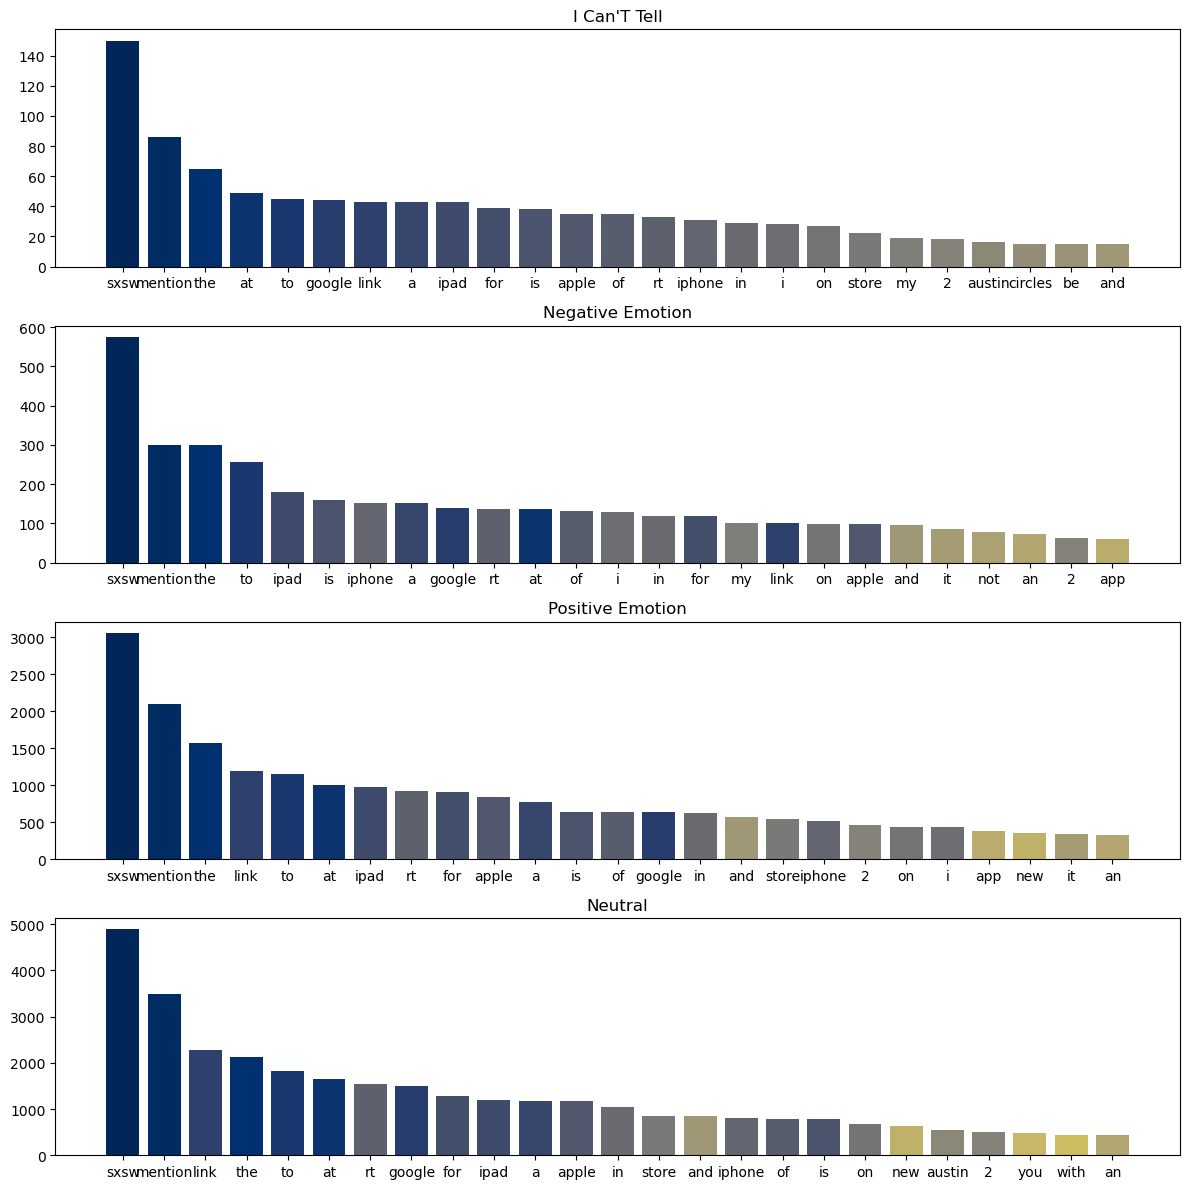

In [36]:
# Set up figure and axes
fig, axes = plt.subplots(nrows=4, figsize=(12, 12))

# Empty dict to hold words that have already been plotted and their colors
plotted_words_and_colors = {}
# Establish color palette to pull from
# (If you get an error message about popping from an empty list, increase this #)
color_palette = sns.color_palette('cividis', n_colors=38)

# Creating a plot for each unique genre
data_by_genre = [y for _, y in concatenated_df.groupby('sentiment', as_index=False)]
for idx, genre_df in enumerate(data_by_genre):
    # Find top 10 words in this genre
    all_words_in_genre = genre_df.tweet_text.explode()
    top_10 = all_words_in_genre.value_counts()[:25]
    
    # Select appropriate colors, reusing colors if words repeat
    colors = []
    for word in top_10.index:
        if word not in plotted_words_and_colors:
            new_color = color_palette.pop(0)
            plotted_words_and_colors[word] = new_color
        colors.append(plotted_words_and_colors[word])
    
    # Select axes, plot data, set title
    ax = axes[idx]
    ax.bar(top_10.index, top_10.values, color=colors)
    ax.set_title(genre_df.iloc[0].sentiment.title())
    
fig.tight_layout()

From the plots above we have identified the following stopwords, to be added to the default nltk stopwords list:
* SXSW - this is a tech conference being referred to thus will not give us any meaning
* Mention - this is a twitter functionality for addressing a particular account
* rt - twitter functionality for retweet
* link - place holder for a url
* the, to, at, a, in, of, is - these and others will be removed by the default stopword list

Below we add the custom stop words identified, then remove them from the corpus

In [37]:
# initialize stopword list
stopwords_list = stopwords.words('english')

# append custom stop words
stop_add = ['sxsw', 'mention', 'rt', 'link']
[stopwords_list.append(s) for s in stop_add]

# remove stopwords
#no_stop = [word for word in concatenated_df.tweet_text[] if word not in stopwords_list]

no_stop = []
# Loop through each row in the "tweet_text" column
for index, row in concatenated_df.iterrows():
    tweet = row['tweet_text']
        
    # Remove stop words from the tweet
    filtered_words = [word for word in tweet if word not in stopwords_list]
    
    # Append the filtered tweet to the list
    no_stop.append(filtered_words)

# add the cleaned stopwords as column to dataframe
concatenated_df['no_stop'] = no_stop
concatenated_df.head()

,tweet_text,brand,sentiment,no_stop
0,"[wesley83, i, have, a, 3g, iphone, after, 3, hrs, tweeting, at, riseaustin, it, was, dead, i, need, to, upgrade, plugin, stations, at, sxsw]",iphone,Negative emotion,"[wesley83, 3g, iphone, 3, hrs, tweeting, riseaustin, dead, need, upgrade, plugin, stations]"
1,"[jessedee, know, about, fludapp, awesome, ipadiphone, app, that, youll, likely, appreciate, for, its, design, also, theyre, giving, free, ts, at, sxsw]",ipad or iphone app,Positive emotion,"[jessedee, know, fludapp, awesome, ipadiphone, app, youll, likely, appreciate, design, also, theyre, giving, free, ts]"
2,"[swonderlin, can, not, wait, for, ipad, 2, also, they, should, sale, them, down, at, sxsw]",ipad,Positive emotion,"[swonderlin, wait, ipad, 2, also, sale]"
3,"[sxsw, i, hope, this, years, festival, isnt, as, crashy, as, this, years, iphone, app, sxsw]",ipad or iphone app,Negative emotion,"[hope, years, festival, isnt, crashy, years, iphone, app]"
4,"[sxtxstate, great, stuff, on, fri, sxsw, marissa, mayer, google, tim, oreilly, tech, booksconferences, amp, matt, mullenweg, wordpress]",google,Positive emotion,"[sxtxstate, great, stuff, fri, marissa, mayer, google, tim, oreilly, tech, booksconferences, amp, matt, mullenweg, wordpress]"


#### Lemmatization
Lemmatization is the process of grouping together different inflected forms of the same word.It gets to links similar meaning words as one word. The goal of lemmatization is to reduce a word to its root form, also called a lemma. For example, the verb "running" would be identified as "run."

We are using Lemmatization over stemming - Stemming is a process that stems or removes last few characters from a word, often leading to incorrect meanings and spelling. Lemmatization considers the context and converts the word to its meaningful base form, which is called Lemma

In [38]:
# initialize the lemmatizer
lem = WordNetLemmatizer()

lema = []
# Loop through each row in the "no_stop" column
for index, row in concatenated_df.iterrows():
    tweet = row['no_stop']
        
    # Remove stop words from the tweet
    lematized_words = [lem.lemmatize(word) for word in tweet]
    
    # Append the filtered tweet to the list
    lema.append(lematized_words)

# add the cleaned stopwords as column to dataframe
concatenated_df['lemmatized'] = lema
concatenated_df.head()


,tweet_text,brand,sentiment,no_stop,lemmatized
0,"[wesley83, i, have, a, 3g, iphone, after, 3, hrs, tweeting, at, riseaustin, it, was, dead, i, need, to, upgrade, plugin, stations, at, sxsw]",iphone,Negative emotion,"[wesley83, 3g, iphone, 3, hrs, tweeting, riseaustin, dead, need, upgrade, plugin, stations]","[wesley83, 3g, iphone, 3, hr, tweeting, riseaustin, dead, need, upgrade, plugin, station]"
1,"[jessedee, know, about, fludapp, awesome, ipadiphone, app, that, youll, likely, appreciate, for, its, design, also, theyre, giving, free, ts, at, sxsw]",ipad or iphone app,Positive emotion,"[jessedee, know, fludapp, awesome, ipadiphone, app, youll, likely, appreciate, design, also, theyre, giving, free, ts]","[jessedee, know, fludapp, awesome, ipadiphone, app, youll, likely, appreciate, design, also, theyre, giving, free, t]"
2,"[swonderlin, can, not, wait, for, ipad, 2, also, they, should, sale, them, down, at, sxsw]",ipad,Positive emotion,"[swonderlin, wait, ipad, 2, also, sale]","[swonderlin, wait, ipad, 2, also, sale]"
3,"[sxsw, i, hope, this, years, festival, isnt, as, crashy, as, this, years, iphone, app, sxsw]",ipad or iphone app,Negative emotion,"[hope, years, festival, isnt, crashy, years, iphone, app]","[hope, year, festival, isnt, crashy, year, iphone, app]"
4,"[sxtxstate, great, stuff, on, fri, sxsw, marissa, mayer, google, tim, oreilly, tech, booksconferences, amp, matt, mullenweg, wordpress]",google,Positive emotion,"[sxtxstate, great, stuff, fri, marissa, mayer, google, tim, oreilly, tech, booksconferences, amp, matt, mullenweg, wordpress]","[sxtxstate, great, stuff, fri, marissa, mayer, google, tim, oreilly, tech, booksconferences, amp, matt, mullenweg, wordpress]"


### Word cloud visualization

A wordcloud is a visualization wherein the most frequent words appear in large size and the less frequent words appear in smaller sizes. 
By highlighting the most frequent terms in a corpus, word clouds can help identify commonly used or repeated words. Conversely, rare or unique terms may also stand out in the visualization, providing insights into less common aspects or specific attributes.

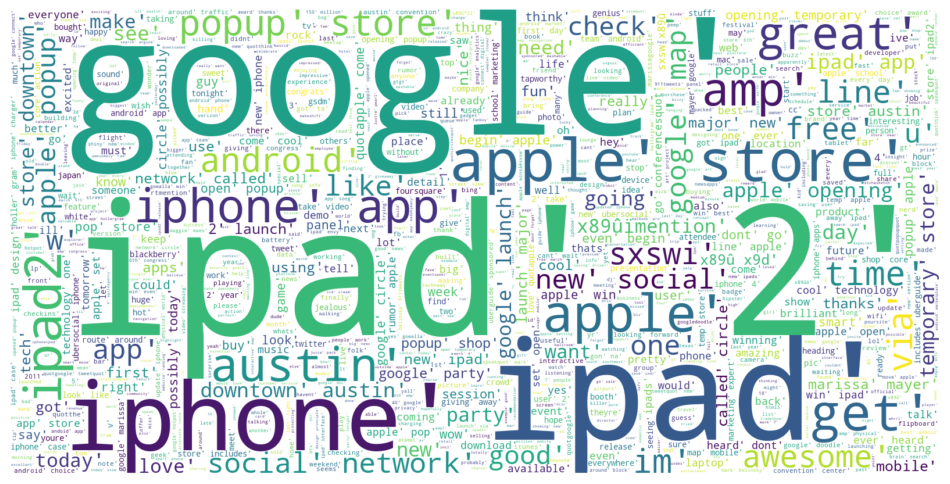

In [40]:
def generate_word_cloud(data, label):
    tweet = " ".join(str(tweet) for tweet in data.loc[data.sentiment == label].lemmatized)
    wordcloud = WordCloud(background_color='white', width=1600, height=800, max_words=2000, min_font_size=5).generate(tweet)
    plt.figure(figsize=(12,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
# Word cloud for the Posititve emotion
generate_word_cloud(concatenated_df,'Positive emotion')

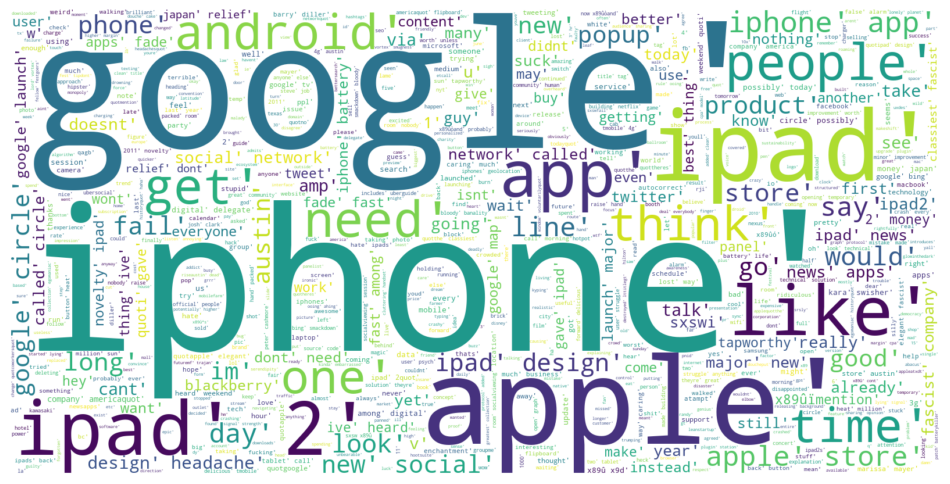

In [41]:
# Word cloud for the neutral emotion
generate_word_cloud(concatenated_df, 'Negative emotion')

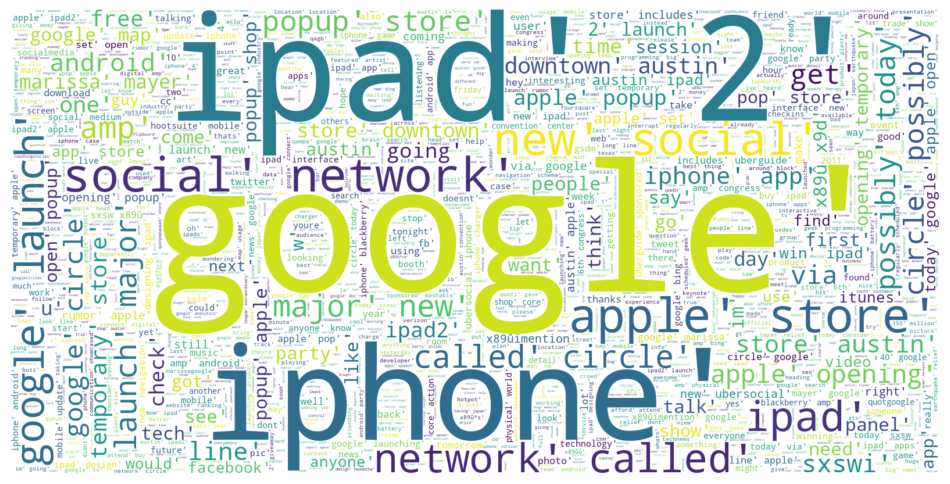

In [42]:
# Word cloud for the Neutral emotion
generate_word_cloud(concatenated_df, 'neutral')

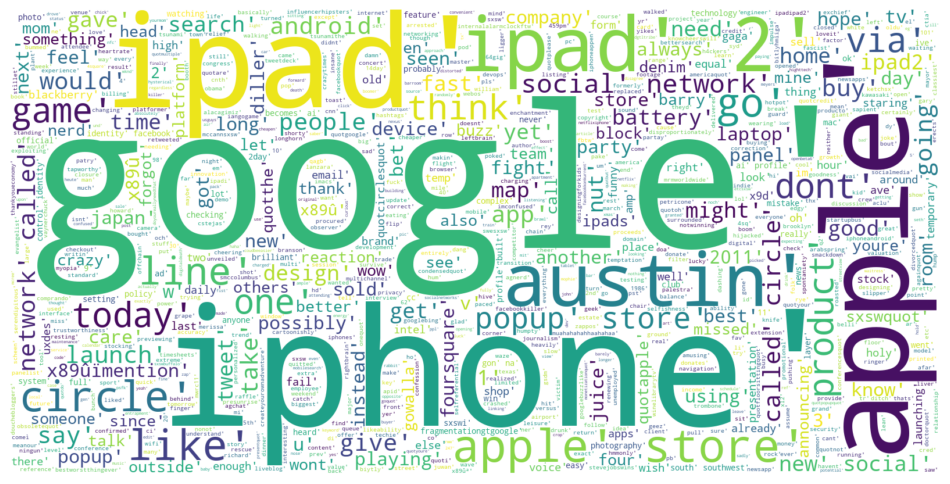

In [43]:
# Word cloud for 'I can't tell'
generate_word_cloud(concatenated_df, "I can't tell")

### Label Encoding

In [44]:
le = LabelEncoder()
concatenated_df['sentiment_target'] = le.fit_transform(concatenated_df.sentiment)
concatenated_df.head()

,tweet_text,brand,sentiment,no_stop,lemmatized,sentiment_target
0,"[wesley83, i, have, a, 3g, iphone, after, 3, hrs, tweeting, at, riseaustin, it, was, dead, i, need, to, upgrade, plugin, stations, at, sxsw]",iphone,Negative emotion,"[wesley83, 3g, iphone, 3, hrs, tweeting, riseaustin, dead, need, upgrade, plugin, stations]","[wesley83, 3g, iphone, 3, hr, tweeting, riseaustin, dead, need, upgrade, plugin, station]",1
1,"[jessedee, know, about, fludapp, awesome, ipadiphone, app, that, youll, likely, appreciate, for, its, design, also, theyre, giving, free, ts, at, sxsw]",ipad or iphone app,Positive emotion,"[jessedee, know, fludapp, awesome, ipadiphone, app, youll, likely, appreciate, design, also, theyre, giving, free, ts]","[jessedee, know, fludapp, awesome, ipadiphone, app, youll, likely, appreciate, design, also, theyre, giving, free, t]",2
2,"[swonderlin, can, not, wait, for, ipad, 2, also, they, should, sale, them, down, at, sxsw]",ipad,Positive emotion,"[swonderlin, wait, ipad, 2, also, sale]","[swonderlin, wait, ipad, 2, also, sale]",2
3,"[sxsw, i, hope, this, years, festival, isnt, as, crashy, as, this, years, iphone, app, sxsw]",ipad or iphone app,Negative emotion,"[hope, years, festival, isnt, crashy, years, iphone, app]","[hope, year, festival, isnt, crashy, year, iphone, app]",1
4,"[sxtxstate, great, stuff, on, fri, sxsw, marissa, mayer, google, tim, oreilly, tech, booksconferences, amp, matt, mullenweg, wordpress]",google,Positive emotion,"[sxtxstate, great, stuff, fri, marissa, mayer, google, tim, oreilly, tech, booksconferences, amp, matt, mullenweg, wordpress]","[sxtxstate, great, stuff, fri, marissa, mayer, google, tim, oreilly, tech, booksconferences, amp, matt, mullenweg, wordpress]",2


Now we have done our text preprocessing part and we will move onto the Vectorization and Model Selection
Vectorization and Model Selection.

### One Hot Encoding

In [45]:
final_df= pd.get_dummies(concatenated_df, columns=['brand'], drop_first=True)

In [46]:
# Convert token lists to strings
final_df["lemmatized"] = final_df["lemmatized"].str.join(" ")

In [47]:
final_df.head()

,tweet_text,sentiment,no_stop,lemmatized,sentiment_target,brand_android app,brand_apple,brand_google,brand_ipad,brand_ipad or iphone app,brand_iphone,brand_itunes,brand_other apple product or service,brand_other google product or service
0,"[wesley83, i, have, a, 3g, iphone, after, 3, hrs, tweeting, at, riseaustin, it, was, dead, i, need, to, upgrade, plugin, stations, at, sxsw]",Negative emotion,"[wesley83, 3g, iphone, 3, hrs, tweeting, riseaustin, dead, need, upgrade, plugin, stations]",wesley83 3g iphone 3 hr tweeting riseaustin dead need upgrade plugin station,1,0,0,0,0,0,1,0,0,0
1,"[jessedee, know, about, fludapp, awesome, ipadiphone, app, that, youll, likely, appreciate, for, its, design, also, theyre, giving, free, ts, at, sxsw]",Positive emotion,"[jessedee, know, fludapp, awesome, ipadiphone, app, youll, likely, appreciate, design, also, theyre, giving, free, ts]",jessedee know fludapp awesome ipadiphone app youll likely appreciate design also theyre giving free t,2,0,0,0,0,1,0,0,0,0
2,"[swonderlin, can, not, wait, for, ipad, 2, also, they, should, sale, them, down, at, sxsw]",Positive emotion,"[swonderlin, wait, ipad, 2, also, sale]",swonderlin wait ipad 2 also sale,2,0,0,0,1,0,0,0,0,0
3,"[sxsw, i, hope, this, years, festival, isnt, as, crashy, as, this, years, iphone, app, sxsw]",Negative emotion,"[hope, years, festival, isnt, crashy, years, iphone, app]",hope year festival isnt crashy year iphone app,1,0,0,0,0,1,0,0,0,0
4,"[sxtxstate, great, stuff, on, fri, sxsw, marissa, mayer, google, tim, oreilly, tech, booksconferences, amp, matt, mullenweg, wordpress]",Positive emotion,"[sxtxstate, great, stuff, fri, marissa, mayer, google, tim, oreilly, tech, booksconferences, amp, matt, mullenweg, wordpress]",sxtxstate great stuff fri marissa mayer google tim oreilly tech booksconferences amp matt mullenweg wordpress,2,0,0,1,0,0,0,0,0,0


### Train Test Split

In [48]:
X= final_df.drop(columns=['sentiment', 'sentiment_target'], axis=1)
y= final_df['sentiment_target']

In [49]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3, random_state=42)

### Modelling

Before we let our data to train we have to numerically represent the preprocessed data. The well-known techniques for vectorization of words in Natural Language Processing are: CountVectorization and Tf-IDF transformation. Let’s dive a bit into the theoretical background of those vectorization techniques.
CountVectorization generates a sparse matrix representing all the words in the document.

In [50]:
# Instantiate CountVectorizer class and fit transform on X_train
vectorizer = CountVectorizer()
train_vec= vectorizer.fit_transform(X_train.lemmatized)

In [51]:
# Transform the test set
test_vec= vectorizer.transform(X_test.lemmatized)

In [52]:
train_df= pd.DataFrame(train_vec.toarray(), columns= vectorizer.get_feature_names_out())
train_df.head()

,02,03,0310,031111,10,100,1000,100000,101,1030,...,ûïview,ûïwin,ûò,ûòand,ûó,ûójust,ûólewis,ûólots,ûómention,ûómy
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
test_df= pd.DataFrame(test_vec.toarray(), columns= vectorizer.get_feature_names_out())
test_df.head()

,02,03,0310,031111,10,100,1000,100000,101,1030,...,ûïview,ûïwin,ûò,ûòand,ûó,ûójust,ûólewis,ûólots,ûómention,ûómy
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
columns_to_drop = ['tweet_text', 'no_stop', 'lemmatized']
X_train.drop(columns_to_drop, axis=1, inplace=True)

In [55]:
train_features= pd.concat([X_train, train_df], axis=1)
train_features.head()

,brand_android app,brand_apple,brand_google,brand_ipad,brand_ipad or iphone app,brand_iphone,brand_itunes,brand_other apple product or service,brand_other google product or service,02,...,ûïview,ûïwin,ûò,ûòand,ûó,ûójust,ûólewis,ûólots,ûómention,ûómy
3267,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7694,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2356,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2362,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
X_test.drop(columns_to_drop, axis=1, inplace=True)

In [57]:
test_features= pd.concat([X_test, test_df], axis=1)
test_features.head()

,brand_android app,brand_apple,brand_google,brand_ipad,brand_ipad or iphone app,brand_iphone,brand_itunes,brand_other apple product or service,brand_other google product or service,02,...,ûïview,ûïwin,ûò,ûòand,ûó,ûójust,ûólewis,ûólots,ûómention,ûómy
2691,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2521,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6939,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
943,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5390,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Logistic Regression

In [ ]:
# Instantiate Logistic Regression
lr= LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)
# Fit on training data
lr.fit(train_vec.toarray(), y_train)